In [1]:
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations

# import semi-core packages
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd

# import open2c libraries
import bioframe

import cooler
import cooltools
import os

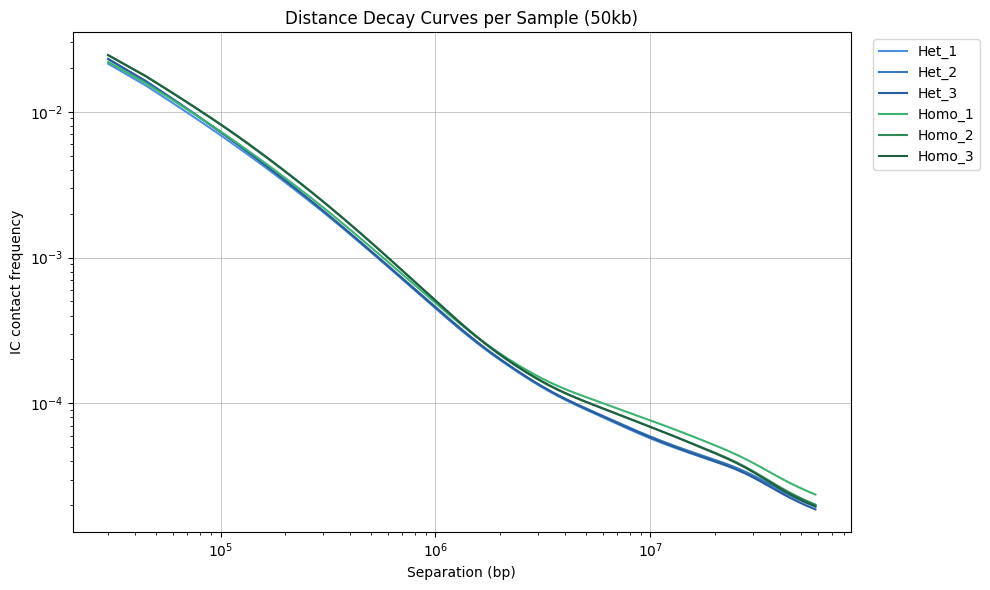

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import cooler
import os

data_dir = '/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output'
samples = [s for s in os.listdir(data_dir) if not s.startswith('.')]

resolution = 15000
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

# 假设你知道具体样本名顺序，比如：
het_samples = sorted([s for s in samples if 'Het' in s])
homo_samples = sorted([s for s in samples if 'Homo' in s])

# 按需求顺序排列
ordered_samples = het_samples + homo_samples

het_colors = ['#4a90e2', '#357ABD', '#2a5d9f']  # 蓝色
homo_colors = ['#3cb371', '#2e8b57', '#206040']  # 绿色

color_map = {}
for i, s in enumerate(het_samples):
    color_map[s] = het_colors[i % len(het_colors)]
for i, s in enumerate(homo_samples):
    color_map[s] = homo_colors[i % len(homo_colors)]

lines = []
labels = []

for sample_name in ordered_samples:
    clr_path = f'{data_dir}/{sample_name}/{sample_name}.valid_pairs.5000.zoomify.mcool::resolutions/50000'
    clr = cooler.Cooler(clr_path)
    
    exp_path = f'{data_dir}/{sample_name}/{sample_name}.expected_cis.aggregate_smoothed.50000.tsv'
    df = pd.read_csv(exp_path, sep='\t')
    df['s_bp'] = df['dist'] * resolution
    df.loc[df['dist'] < 2, 'balanced.avg.smoothed.agg'] = np.nan
    
    autosomes = clr.chromnames[:19]
    df_auto = df[df['region1'].isin(autosomes)]
    grouped = df_auto.groupby('s_bp')['balanced.avg.smoothed.agg'].median().reset_index()
    
    color = color_map.get(sample_name, 'black')
    line, = ax.plot(grouped['s_bp'], grouped['balanced.avg.smoothed.agg'], label=sample_name, color=color)
    
    lines.append(line)
    labels.append(sample_name)

ax.set(
    xlabel='Separation (bp)',
    ylabel='IC contact frequency',
    xscale='log',
    yscale='log'
)
ax.grid(True, lw=0.5)

# 用指定顺序绘制legend
ax.legend(lines, labels, bbox_to_anchor=(1.02, 1), loc='upper left')

plt.title("Distance Decay Curves per Sample (50kb)")
plt.tight_layout()
plt.savefig('../plots_v1/distance_decay_curves_50kb_resolution.pdf', dpi=300, bbox_inches='tight')
plt.show()
